## Notebook for Figures 6 and 7

In [1]:
%matplotlib inline

import numpy as np
from tqdm.notebook import tqdm
import xarray as xr

#Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import cartopy.crs as ccrs

from one_pass import __version__ as one_pass_version
from one_pass.opa import Opa
from utils import read_or_download_dataset

print(f"One_Pass version: {one_pass_version}")

One_Pass version: 0.7.2


## Examining the rolling variance of the rolling mean of the temperature data

In [2]:
# Download data if not present
url = "https://zenodo.org/records/12533197/files/2t_march_2020_IFS_tco2559_ng5_cycle3_r050.nc?download=1"
filename = "2t_2020.nc"
ds = read_or_download_dataset(filename, url)
temp = ds['2t']
temp

<xarray.DataArray '2t' (time: 744, lat: 360, lon: 720)> Size: 2GB
array([[[236.70312128, 236.70312128, 236.70312128, ..., 236.70312128,
         236.70312128, 236.70312128],
        [237.35664811, 237.35664811, 237.35664811, ..., 237.34792533,
         237.35664811, 237.35664811],
        [238.414032  , 238.414032  , 238.3867933 , ..., 238.47855657,
         238.43212738, 238.414032  ],
        ...,
        [250.76372162, 250.76372162, 250.75036303, ..., 250.81291328,
         250.7760744 , 250.76372162],
        [249.78262303, 249.78262303, 249.78262303, ..., 249.80115874,
         249.78262303, 249.78262303],
        [248.77753111, 248.77753111, 248.77753111, ..., 248.77753111,
         248.77753111, 248.77753111]],

       [[236.86453501, 236.86453501, 236.86453501, ..., 236.86453501,
         236.86453501, 236.86453501],
        [237.17998636, 237.17998636, 237.17998636, ..., 237.20152572,
         237.17998636, 237.17998636],
        [238.18816353, 238.18816353, 238.18199022, ..., 238.2110852 ,
         238.18396223, 238.18816353],
...
        [253.69818567, 253.69818567, 253.71890719, ..., 253.65644736,
         253.69190155, 253.69818567],
        [254.06327015, 254.06327015, 254.06327015, ..., 254.06409768,
         254.06327015, 254.06327015],
        [254.31562855, 254.31562855, 254.31562855, ..., 254.31562855,
         254.31562855, 254.31562855]],

       [[224.52346138, 224.52346138, 224.52346138, ..., 224.52346138,
         224.52346138, 224.52346138],
        [223.99545848, 223.99545848, 223.99545848, ..., 223.96961225,
         223.99545848, 223.99545848],
        [224.11385919, 224.11385919, 224.10501233, ..., 224.18426089,
         224.13597617, 224.11385919],
        ...,
        [254.22458258, 254.22458258, 254.24124601, ..., 254.18906697,
         254.21596889, 254.22458258],
        [254.39612271, 254.39612271, 254.39612271, ..., 254.38855502,
         254.39612271, 254.39612271],
        [254.57853422, 254.57853422, 254.57853422, ..., 254.57853422,
         254.57853422, 254.57853422]]], shape=(744, 360, 720))
Coordinates:
  * time     (time) datetime64[ns] 6kB 2020-03-01 ... 2020-03-31T23:00:00
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 6kB 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
Attributes: (12/17)
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    regridded:                  1
    history:                    \n2024-05-15 12:26:44 AQUA💧: Regrid from tco2...

First we define a function to convert the one pass cumulative M2 into actual variance by dividing by the number of samples

We then calculate the one-pass mean but storing the output after every data chunk is passed. Storing the mean and the variance after each chunk is passed.

In [3]:
step = 1

# creating an empty array to store the updated means at every time step
temp_mean_continuous = np.zeros_like(temp)
temp_mean_continuous_var = np.zeros_like(temp)

opa_mean = Opa({
    "variable": "2t",
    "stat": "mean",
    "stat_freq": "continuous",
    "output_freq": "hourly",
    "time_step": 60,  # in minutes, set up for daily data
    "checkpoint": False,
    "save": False,
})
opa_var = Opa({
    "variable": "2t",
    "stat": "var",
    "stat_freq": "continuous",
    "output_freq": "hourly",
    "time_step": 60,  # in minutes, set up for daily data
    "checkpoint": False,
    "save": False,
})

for hour in tqdm(range(0, len(temp.time), step)):
    incoming_data_chunk = temp.isel(time = slice(hour, hour + step))
    result_mean = opa_mean.compute(incoming_data_chunk)
    result_var = opa_var.compute(result_mean)
    temp_mean_continuous[hour, :, :] = result_mean["2t"][0, :, :]
    temp_mean_continuous_var[hour, :, :] = result_var["2t"][0, :, :]

  0%|          | 0/744 [00:00<?, ?it/s]

## Now doing the same for the wind speed data

In [4]:
filename = "ws_2020.nc"
url = "https://zenodo.org/records/12533197/files/wind_speed_dec_2020_IFS_tco2559_ng5_cycle3_r100.nc?download=1"
ds = read_or_download_dataset(filename, url)
ws = ds["wind_speed_rms_u10_v10"]
ws

<xarray.DataArray 'wind_speed_rms_u10_v10' (time: 744, lat: 180, lon: 360)> Size: 386MB
array([[[2.93954986, 2.93954986, 2.93954986, ..., 2.93954986,
         2.93954986, 2.93954986],
        [2.02834246, 2.02834246, 2.16021619, ..., 2.04527919,
         2.04527919, 2.02834246],
        [2.42472662, 2.59550694, 2.59550694, ..., 1.97438638,
         2.05842668, 2.05842668],
        ...,
        [6.28958   , 6.36987678, 6.40751573, ..., 6.05260538,
         6.11254763, 6.22192421],
        [6.45764074, 6.50447068, 6.50447068, ..., 6.3285863 ,
         6.37498269, 6.37498269],
        [4.61811748, 4.61811748, 4.57383299, ..., 4.60146774,
         4.60146774, 4.61811748]],

       [[2.90798484, 2.90798484, 2.90798484, ..., 2.90798484,
         2.90798484, 2.90798484],
        [2.05873427, 2.05873427, 2.16232496, ..., 2.07912831,
         2.07912831, 2.05873427],
        [2.31352278, 2.4341974 , 2.4341974 , ..., 2.00608275,
         2.04463433, 2.04463433],
...
        [6.20905854, 6.2251049 , 6.21148682, ..., 6.44377228,
         6.33001275, 6.20983875],
        [7.90726166, 7.86109816, 7.86109816, ..., 7.96606172,
         7.91285179, 7.91285179],
        [9.31319453, 9.31319453, 9.25495986, ..., 9.35522777,
         9.35522777, 9.31319453]],

       [[4.34423047, 4.34423047, 4.34423047, ..., 4.34423047,
         4.34423047, 4.34423047],
        [4.88380951, 4.88380951, 5.0579028 , ..., 4.66345466,
         4.66345466, 4.88380951],
        [2.68537985, 2.82075879, 2.82075879, ..., 2.53503505,
         2.63599783, 2.63599783],
        ...,
        [6.60779603, 6.54613556, 6.52197662, ..., 6.85647524,
         6.79409514, 6.68401349],
        [8.21272222, 8.16978546, 8.16978546, ..., 8.2483985 ,
         8.21679793, 8.21679793],
        [9.29370667, 9.29370667, 9.26157761, ..., 9.31457748,
         9.31457748, 9.29370667]]], shape=(744, 180, 360))
Coordinates:
  * time     (time) datetime64[ns] 6kB 2020-12-01 ... 2020-12-31T23:00:00
  * lat      (lat) float64 1kB -89.95 -88.95 -87.95 -86.95 ... 87.05 88.05 89.05
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Attributes: (12/17)
    paramId:                    228246
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    regridded:                  1
    history:                    \n2024-03-12 10:26:45 AQUA💧: Regrid from tco2...

Extract dataarray of wind speed

In [5]:
step = 1

# creating an empty array to store the updated means and variances at every time step
ws_mean_continuous = np.zeros_like(ws)
ws_mean_continuous_var = np.zeros_like(ws)

opa_mean = Opa({
    "variable": "wind_speed_rms_u10_v10",
    "stat": "mean",
    "stat_freq": "continuous",
    "output_freq": "hourly",
    "time_step": 60,  # in minutes, set up for daily data
    "checkpoint": False,
    "save": False,
})
opa_var = Opa({
    "variable": "wind_speed_rms_u10_v10",
    "stat": "var",
    "stat_freq": "continuous",
    "output_freq": "hourly",
    "time_step": 60,  # in minutes, set up for daily data
    "checkpoint": False,
    "save": False,
})

for hour in tqdm(range(0, len(ws.time), step)):

    incoming_data_chunk = ws.isel(time = slice(hour, hour + step))
    result_mean = opa_mean.compute(incoming_data_chunk)
    result_var = opa_var.compute(result_mean)
    ws_mean_continuous[hour, :, :] = result_mean["wind_speed_rms_u10_v10"][0, :, :]
    ws_mean_continuous_var[hour, :, :] = result_var["wind_speed_rms_u10_v10"][0, :, :]

  0%|          | 0/744 [00:00<?, ?it/s]

## Now looking at the 50th percentile of precipitation

In [6]:
density = 998 # kg/m3 
filename = "pr_2021.nc"
url = "https://zenodo.org/records/12533197/files/pr_aug_2021_ICON_ngc2009_cycle3_r100.nc?download=1"
ds = read_or_download_dataset(filename, url)
pr = ds["pr"]
pr = (pr / density) * 1000  * 60 * 60 * 24
pr

<xarray.DataArray 'pr' (time: 1488, lat: 180, lon: 360)> Size: 771MB
array([[[ 0.35476521,  0.3584283 ,  0.35923951, ...,  0.34042391,
          0.34482389,  0.34999642],
        [ 0.42305696,  0.4037038 ,  0.39491505, ...,  0.53555754,
          0.48751938,  0.45044463],
        [ 1.26833425,  1.31007606,  1.27717774, ...,  1.2376468 ,
          1.2383661 ,  1.23805273],
        ...,
        [14.95715725, 15.3591962 , 15.65228986, ..., 12.45017988,
         13.46204004, 14.29664279],
        [18.53019263, 18.89931626, 19.21713503, ..., 16.96858285,
         17.55401379, 18.08884688],
        [ 5.5387552 ,  5.6823863 ,  5.75625108, ...,  5.08945107,
          5.24148886,  5.37808198]],

       [[ 0.34198112,  0.33326578,  0.32495688, ...,  0.36422862,
          0.35845508,  0.35074568],
        [ 0.38018258,  0.35615595,  0.34340842, ...,  0.52415646,
          0.46285261,  0.41541373],
        [ 1.06328918,  1.01380104,  0.94403776, ...,  1.00062042,
          1.0985489 ,  1.09978387],
...
        [ 1.12215887,  1.1219173 ,  1.1184685 , ...,  1.10533687,
          1.12553828,  1.12699169],
        [ 1.19836833,  1.23381714,  1.29013499, ...,  1.19114227,
          1.19181235,  1.18654145],
        [ 2.13260971,  2.24715622,  2.3744818 , ...,  1.83713445,
          1.92539412,  2.01977969]],

       [[ 0.24761743,  0.24870042,  0.25106095, ...,  0.25013133,
          0.24794803,  0.24692503],
        [ 0.06990208,  0.08223832,  0.10098687, ...,  0.04879396,
          0.05435478,  0.06100431],
        [ 0.17611756,  0.13948908,  0.10637705, ...,  0.2196375 ,
          0.22013666,  0.20623171],
        ...,
        [ 1.15115261,  1.15492853,  1.18113447, ...,  1.20439936,
          1.17363857,  1.15582775],
        [ 1.38134412,  1.38749079,  1.38686311, ...,  1.23880962,
          1.30823389,  1.3612082 ],
        [ 1.62788808,  1.71343034,  1.80453939, ...,  1.36997041,
          1.45497484,  1.53998723]]], shape=(1488, 180, 360))
Coordinates:
  * time     (time) datetime64[ns] 12kB 2021-08-01 ... 2021-08-31T23:30:00
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0

Extracting preciptiation data and converting units

First, we initalise an array to store the continuous value. Then, looping through the whole precipitation grid in streaming mode and extracting the 50th percentile at every time step. 

Note this code takes approximately 4 hours to run (in serial) as the quantile estimate is being extracted after every data chunk

The results of the code above can be loaded directly as well.

In [7]:
filename = "pr_50th_converge_ICON_r100.nc"
url = "https://zenodo.org/records/12533197/files/precip_50th_converge_ICON_r100_reshaped.nc?download=1"
pr_50per_continuous = read_or_download_dataset(filename, url)
pr_50per_continuous

<xarray.Dataset> Size: 771MB
Dimensions:                        (time: 1488, lat: 180, lon: 360)
Coordinates:
  * time                           (time) datetime64[ns] 12kB 2021-08-01 ... ...
  * lat                            (lat) float64 1kB -89.5 -88.5 ... 88.5 89.5
  * lon                            (lon) float64 3kB 0.0 1.0 2.0 ... 358.0 359.0
Data variables:
    __xarray_dataarray_variable__  (time, lat, lon) float64 771MB 4.098e-06 ....

Then in the same as with the continuous means, taking the continous varience of the 50th percentiles

In [8]:
step = 1

# creating an empty array to store the updated means and variances at every time step
pr_50per_continuous_var = np.zeros_like(pr)

# In OPA v0.7.2 there is no output_freq "half_hourly" available. For that reason, we set it to "monthly", then look at the opa_stat internal cumulative variance
opa_stat = Opa({
    "variable": "pr",
    "stat": "var",
    "stat_freq": "continuous",
    "output_freq": "monthly",
    "time_step": 30,  # in minutes, set up for daily data
    "checkpoint": False,
    "save": False,
})

for n, half_hour in tqdm(enumerate(range(0, len(pr_50per_continuous.time), step), start=1), total=len(pr_50per_continuous.time) // step):
    incoming_data_chunk = pr_50per_continuous.isel(time = slice(half_hour, half_hour + step))
    result = opa_stat.compute(incoming_data_chunk.to_dataarray())
    pr_50per_continuous_var[half_hour, :, :] = (opa_stat.statistics.var_cum[0, :, :] / max(1, n - 1))

  0%|          | 0/1488 [00:00<?, ?it/s]

# Looking at convergence

Now we 6 data sets: the rollling mean of temperature and wind speed, along with the 50th percentile of precipitiaton, and the rolling variance of all of these data sets. We now to look to see how these rolling variances converege

In [9]:
# first converting all the arrays in xr.DataArrays

temp_mean_continuous = xr.DataArray(temp_mean_continuous, dims=['time', 'lat', 'lon'], 
                                 coords={'time': temp.time,
                                        'lat': temp.lat,
                                        'lon': temp.lon})

temp_mean_continuous_var = xr.DataArray(temp_mean_continuous_var, dims=['time', 'lat', 'lon'], 
                                 coords={'time': temp.time,
                                        'lat': temp.lat,
                                        'lon': temp.lon})

ws_mean_continuous = xr.DataArray(ws_mean_continuous, dims=['time', 'lat', 'lon'], 
                                 coords={'time': ws.time,
                                        'lat': ws.lat,
                                        'lon': ws.lon})

ws_mean_continuous_var = xr.DataArray(ws_mean_continuous_var, dims=['time', 'lat', 'lon'], 
                                 coords={'time': ws.time,
                                        'lat': ws.lat,
                                        'lon': ws.lon})

pr_50per_continuous_var = xr.DataArray(pr_50per_continuous_var, dims=['time', 'lat', 'lon'], 
                                 coords={'time': pr.time,
                                        'lat': pr.lat,
                                        'lon': pr.lon})

Starting with temperature.

In [10]:
# looking for a sequence with a set CI 
start = 2 

temp_converg = xr.zeros_like(temp_mean_continuous_var[0,:,:])
temp_converg_seq = xr.zeros_like(temp_mean_continuous[:,:,:])
less_tol = xr.zeros_like(temp_mean_continuous_var[0,:,:])

# taking the sequence as the standard deviation
sequence = np.sqrt(temp_mean_continuous_var[:, :, :])
temp_std = sequence

# setting the threshold and tolerance for converegence
convergence_limit = 0
tol = 0.005
threshold_up = 1 + tol
threshold_down = 1 - tol

num_conv = 20

for w in range(start, len(sequence)):

    temp_converg_seq[w-start,:,:] = abs(sequence[w, :, :] - convergence_limit)/abs(sequence[w-1, :, :] - convergence_limit)**1
    # if falls within the tolerance range add 1 
    less_tol = less_tol.where(threshold_up < temp_converg_seq[w-start,:,:], less_tol + 1, 0)
    # if falls outside of the tolerance range make it 0 
    less_tol = less_tol.where(threshold_down < temp_converg_seq[w-start,:,:], 0)
    # if it's had num_conv consecutive values within the tolerance range mark as done 
    temp_converg = temp_converg.where(temp_converg != 0, temp_converg.where(less_tol != num_conv, w))

temp_converg = temp_converg - num_conv - start

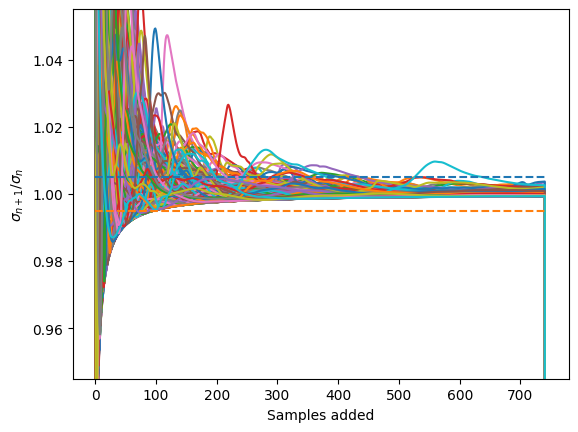

In [11]:
xaxis = np.linspace(0, len(temp_mean_continuous.time[start:]), len(temp_mean_continuous.time[start:]))

# randomly looking at some of the grid cells
for q in range(0, len(temp_mean_continuous_var.lat), 20):
    for e in range(0, len(temp_mean_continuous_var.lon), 50):
        plt.plot(xaxis, temp_converg_seq[start:,q,e], linestyle='-')

plt.xlabel('Samples added')
plt.plot(xaxis, np.linspace(threshold_up, threshold_up, len(temp_mean_continuous.time[start:])), linestyle='--')
plt.plot(xaxis, np.linspace(threshold_down, threshold_down, len(temp_mean_continuous.time[start:])), linestyle='--')
plt.ylabel(r'$\sigma_{n+1}/ \sigma_{n}$')
plt.ylim([threshold_down - 10*tol, threshold_up + 10*tol])
plt.show()

Doing the same analysis with the wind speed data

In [12]:
start = 2 

ws_converg = xr.zeros_like(ws_mean_continuous_var[0,:,:])
ws_converg_seq = xr.zeros_like(ws_mean_continuous[:,:,:])
less_tol = xr.zeros_like(ws_mean_continuous_var[0,:,:])

# taking the sequence as the standard deviation
sequence = np.sqrt(ws_mean_continuous_var[:, :, :])
ws_std = sequence

# setting the threshold and tolerance for converegence
convergence_limit = 0
tol = 0.005
threshold_up = 1 + tol
threshold_down = 1 - tol

num_conv = 20

for w in range(start, len(sequence)):

    ws_converg_seq[w-start,:,:] = abs(sequence[w, :, :] - convergence_limit)/abs(sequence[w-1, :, :] - convergence_limit)**1
    # if falls within the tolerance range add 1 
    less_tol = less_tol.where(threshold_up < ws_converg_seq[w-start,:,:], less_tol + 1, 0)
    # if falls outside of the tolerance range make it 0
    less_tol = less_tol.where(threshold_down < ws_converg_seq[w-start,:,:], 0)
    # if it's had num_conv consecutive values within the tolerance range mark as done 
    ws_converg = ws_converg.where(ws_converg != 0, ws_converg.where(less_tol != num_conv, w))

ws_converg = ws_converg - num_conv - start

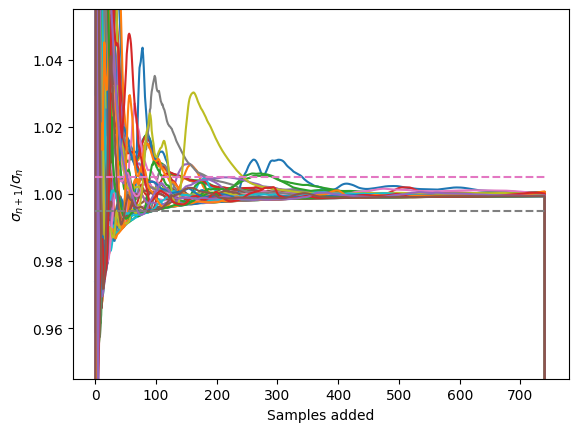

In [13]:
xaxis = np.linspace(0, len(ws_mean_continuous.time[start:]), len(ws_mean_continuous.time[start:]))

# randomly looking at some of the grid cells
for q in range(0, len(ws_mean_continuous_var.lat), 20):
    for e in range(0, len(ws_mean_continuous_var.lon), 100):
        plt.plot(xaxis, ws_converg_seq[start:,q,e], linestyle='-')

plt.xlabel('Samples added')
plt.plot(xaxis, np.linspace(threshold_up, threshold_up, len(ws_mean_continuous.time[start:])), linestyle='--')
plt.plot(xaxis, np.linspace(threshold_down, threshold_down, len(ws_mean_continuous.time[start:])), linestyle='--')
plt.ylabel(r'$\sigma_{n+1}/ \sigma_{n}$')
plt.ylim([threshold_down - 10*tol, threshold_up + 10*tol])
plt.show()

Finally looking at how the precipitation converges

In [14]:
start = 2 

pr_converg = xr.zeros_like(pr_50per_continuous_var[0,:,:])
pr_converg_seq = xr.zeros_like(pr_50per_continuous.to_dataarray()[0, :, :, :])
less_tol = xr.zeros_like(pr_50per_continuous_var[0,:,:])

# taking the sequence as the standard deviation
sequence = np.sqrt(pr_50per_continuous_var[:, :, :])
pr_std = sequence

# setting the threshold and tolerance for converegence
convergence_limit = 0
tol = 0.005
threshold_up = 1 + tol
threshold_down = 1 - tol

num_conv = 20

for w in range(start, len(sequence)):

    pr_converg_seq[w-start,:,:] = abs(sequence[w, :, :] - convergence_limit)/abs(sequence[w-1, :, :] - convergence_limit)**1
    # if falls within the tolerance range add 1 
    less_tol = less_tol.where(threshold_up < pr_converg_seq[w-start,:,:], less_tol + 1, 0)
    # if falls outside of the tolerance range make it 0
    less_tol = less_tol.where(threshold_down < pr_converg_seq[w-start,:,:], 0)
    # if it's had num_conv consecutive values within the tolerance range mark as done 
    pr_converg = pr_converg.where(pr_converg != 0, pr_converg.where(less_tol != num_conv, w))

pr_converg = pr_converg - num_conv - start

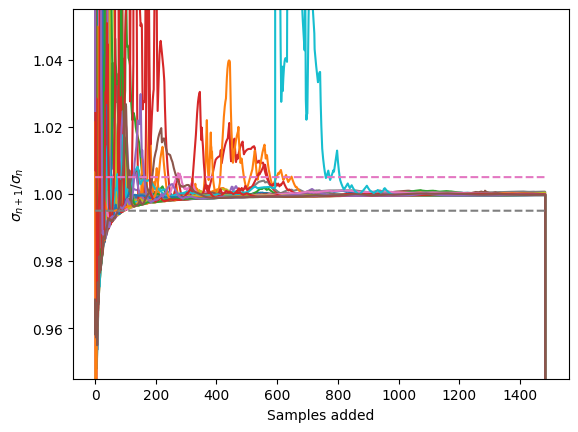

In [15]:
xaxis = np.linspace(0, len(pr_50per_continuous.time[start:]), len(pr_50per_continuous.time[start:]))

# randomly looking at some of the grid cells
for q in range(0, len(pr_50per_continuous_var.lat), 20):
    for e in range(0, len(pr_50per_continuous_var.lon), 100):
        plt.plot(xaxis, pr_converg_seq[start:,q,e], linestyle='-')

plt.xlabel('Samples added')
plt.plot(xaxis, np.linspace(threshold_up, threshold_up, len(pr_50per_continuous.time[start:])), linestyle='--')
plt.plot(xaxis, np.linspace(threshold_down, threshold_down, len(pr_50per_continuous.time[start:])), linestyle='--')
plt.ylabel(r'$\sigma_{n+1}/ \sigma_{n}$')
plt.ylim([threshold_down - 10*tol, threshold_up + 10*tol])
plt.show()

Creating the plot seen in the paper using the temperature data set as an example. The plots above are to show that this shape is seen across all the data sets

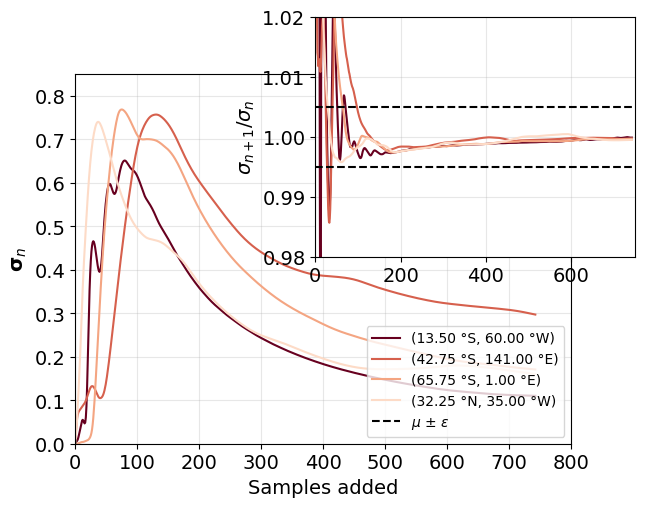

In [16]:
start = 0

# picking rando
c1 = '#67001f'
x1 = 600
y1 = 152

c2 = '#d6604d'
x2 = 282
y2 = 94

c3 = '#f4a582'
x3 = 2
y3 = 48

c4 = '#fddbc7'
x4 = 650
y4 = 250 

fs = 14 

x = [x1, x2, x3, x4]
y = [y1, y2, y3, y4]
color = [c1, c2, c3, c4]
last = -2

xaxis = np.linspace(0, len(temp_mean_continuous.time[0:last]), len(temp_mean_continuous.time[0:last]))
fig, ax1 = plt.subplots()
ax2 = fig.add_axes([0.5, 0.5, 0.5, 0.5]) 

for q in range(0, 4):
    ax2.plot(xaxis, temp_converg_seq[0:last,y[q],x[q]], linestyle='-', color = color[q])
    
for q in range(0, 4):
    if q == 0:
        ax1.plot(xaxis, temp_mean_continuous_var[0:last,y[q],x[q]], linestyle='-', color = color[q],
                 label = '(13.50 °S, 60.00 °W)')
    if q == 1:
        ax1.plot(xaxis, temp_mean_continuous_var[0:last,y[q],x[q]], linestyle='-', color = color[q],
                label = '(42.75 °S, 141.00 °E)')    
    if q == 2:
        ax1.plot(xaxis, temp_mean_continuous_var[0:last,y[q],x[q]], linestyle='-', color = color[q],
                label = '(65.75 °S, 1.00 °E)')
    if q == 3:
        ax1.plot(xaxis, temp_mean_continuous_var[0:last,y[q],x[q]], linestyle='-', color = color[q],
                label = '(32.25 °N, 35.00 °W)')
    
ax2.plot(xaxis, 
         np.linspace(threshold_up, threshold_up, len(temp_mean_continuous.time[start:last])), 
         linestyle='--', color = 'k')
ax2.plot(xaxis, 
         np.linspace(threshold_down, threshold_down, len(temp_mean_continuous.time[start:last])), 
         linestyle='--', color = 'k')

ax1.plot(np.linspace(0,0.01, 10), 
         np.linspace(0, 0.01, 10), 
         linestyle='--', color = 'k', label = r'$\mu$ $\pm$ $\epsilon$')

ax1.set_ylabel(r'$\mathbf{\sigma}_n$', fontsize = fs)
ax1.set_xlabel('Samples added', fontsize = fs)
ax1.legend(loc = 'lower right')
ax2.set_ylabel(r'$\sigma_{n+1}/ \sigma_{n}$', fontsize = fs)

ax1.tick_params(axis='y', labelcolor='black', labelsize = fs)
ax1.tick_params(axis='x', labelcolor='black', labelsize = fs)

ax2.tick_params(axis='y', labelcolor='black', labelsize = fs)
ax2.tick_params(axis='x', labelcolor='black', labelsize = fs)

ax2.grid(True, alpha = 0.3)
ax1.grid(True, alpha = 0.3)

ax1.set_xlim([0, 800])
ax1.set_ylim([0, 0.85])

ax2.set_xlim([0, 750])
ax2.set_ylim([threshold_down - tol*3, threshold_up + tol*3])

plt.show()

Final figure

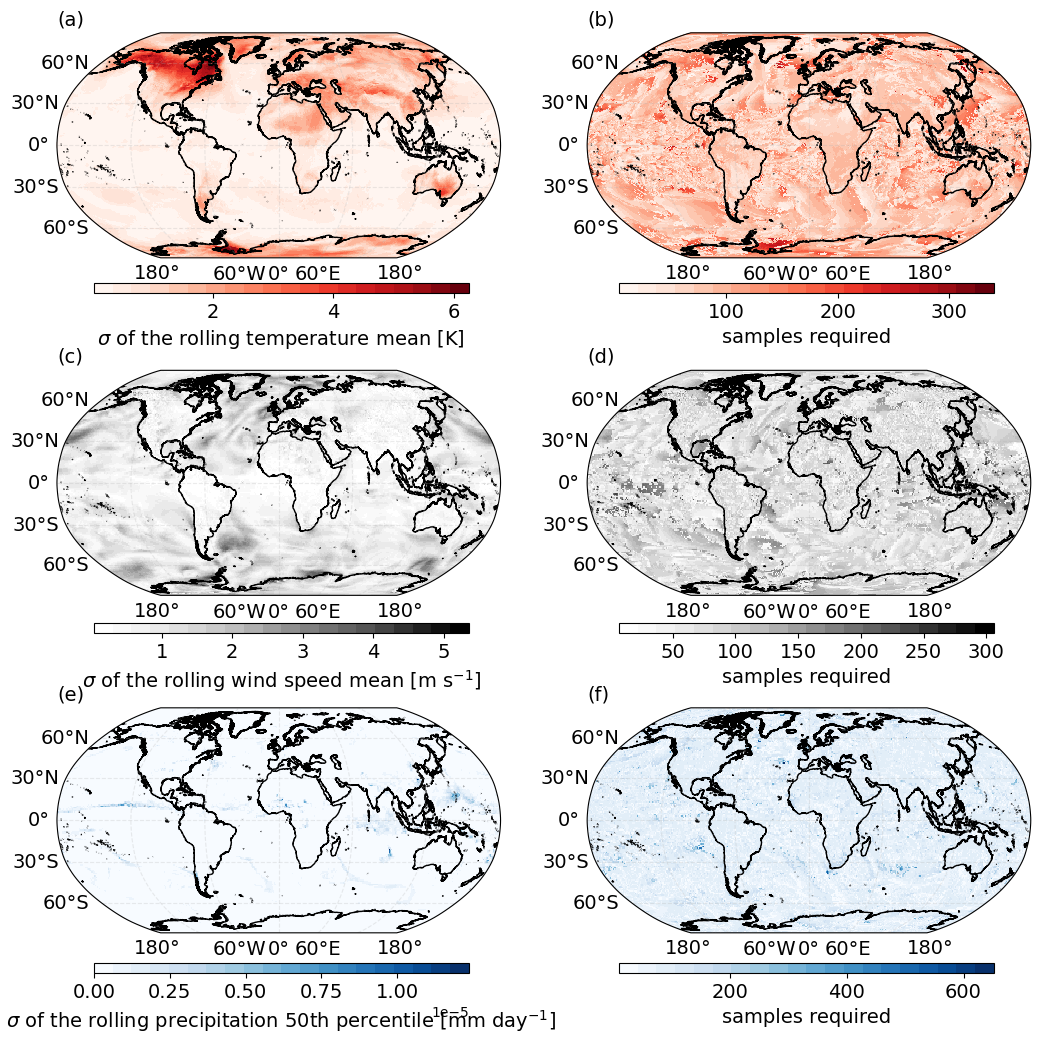

In [17]:
robinson = ccrs.Robinson()
geodetic = ccrs.Geodetic()
fig = plt.figure(constrained_layout=False, figsize=(15,10))
fig.subplots_adjust(bottom=0.05, top=0.95, left=0.15, right=0.85, wspace = 0.42, hspace = 0.05)
nrow = 3
ncol = 2
outer = gs.GridSpec(nrow,ncol,wspace=0.02,hspace=0.5, width_ratios=[1, 1])
fsize = 14
fsize_small = 10

# setting locations for the global maps
width = 0.25
left1 = 0.2
left2 = 0.55
bottom1 = 0.01
bottom2 = 0.35
bottom3 = 0.69

for i in range(nrow*ncol):
    ax = plt.subplot(outer[i],projection = robinson)
    ax.coastlines(resolution = '10m')
    gl = ax.gridlines(draw_labels = True,linestyle='dashed',alpha=0.25)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': fsize}
    gl.ylabel_style = {'size': fsize}
    lon2d,lat2d = np.meshgrid(temp_mean_continuous_var.lon,temp_mean_continuous_var.lat)
    lon2d_s,lat2d_s = np.meshgrid(ws_mean_continuous_var.lon,ws_mean_continuous_var.lat)

    if i == 0:

        cmap = plt.get_cmap('Reds', 20)
        cs = ax.pcolormesh(lon2d, lat2d, temp_std[-1,:,:], transform=ccrs.PlateCarree(),cmap=cmap)
        ax.set_title('(a)', fontsize=fsize, loc = 'left')
        cbar_ax = fig.add_axes([left1, bottom3, width, 0.01])
        cbar = fig.colorbar(cs,cax = cbar_ax ,orientation='horizontal')
        cbar.set_label(r"$\sigma$" " of the rolling temperature mean [K]", rotation=0, fontsize=fsize)

    elif i == 1:

        cs = ax.pcolormesh(lon2d, lat2d, temp_converg, transform=ccrs.PlateCarree(),cmap=cmap)
        ax.set_title('(b)', fontsize=fsize, loc = 'left')
        cbar_ax = fig.add_axes([left2, bottom3, width, 0.01])
        cbar = fig.colorbar(cs,cax = cbar_ax ,orientation='horizontal')
        cbar.set_label("samples required" ,rotation=0, fontsize=fsize)

    elif i == 2:
        cmap = plt.get_cmap('Grays', 20)
        
        cs = ax.pcolormesh(lon2d_s, lat2d_s, ws_std[-1,:,:], transform=ccrs.PlateCarree(),cmap=cmap)
        ax.set_title('(c)', fontsize=fsize, loc = 'left')
        cbar_ax = fig.add_axes([left1, bottom2, width, 0.01])
        cbar = fig.colorbar(cs,cax = cbar_ax ,orientation='horizontal')
        cbar.set_label(r"$\sigma$ of the rolling wind speed mean [m s$^{-1}$]" ,rotation=0, fontsize=fsize)
        
    elif i == 3:

        cs = ax.pcolormesh(lon2d_s, lat2d_s, ws_converg, transform=ccrs.PlateCarree(),cmap=cmap)
        ax.set_title('(d)', fontsize=fsize, loc = 'left')
        cbar_ax = fig.add_axes([left2, bottom2, width, 0.01])
        cbar = fig.colorbar(cs,cax = cbar_ax ,orientation='horizontal')
        cbar.set_label("samples required" ,rotation=0, fontsize=fsize)
        
    elif i == 4:
        
        cmap = plt.get_cmap('Blues', 20)
        cs = ax.pcolormesh(lon2d_s, lat2d_s, pr_std[-1,:,:], transform=ccrs.PlateCarree(),cmap=cmap)
        ax.set_title('(e)', fontsize=fsize, loc = 'left')
        cbar_ax = fig.add_axes([left1, bottom1, width, 0.01])
        cbar = fig.colorbar(cs,cax = cbar_ax ,orientation='horizontal')
        cbar.set_label(r"$\sigma$ of the rolling precipitation 50th percentile [mm day$^{-1}$]" ,rotation=0, fontsize=fsize)
        
    elif i == 5:

        cs = ax.pcolormesh(lon2d_s, lat2d_s, pr_converg, transform=ccrs.PlateCarree(),cmap=cmap)
        ax.set_title('(f)', fontsize=fsize, loc = 'left')
        cbar_ax = fig.add_axes([left2, bottom1, width, 0.01])
        cbar = fig.colorbar(cs,cax = cbar_ax ,orientation='horizontal')
        cbar.set_label("samples required" ,rotation=0, fontsize=fsize)
        
    cbar.ax.tick_params(labelsize=fsize)

plt.show()

In [18]:
np.mean(temp_converg)

<xarray.DataArray ()> Size: 8B
array(81.79863812)
Coordinates:
    time     datetime64[ns] 8B 2020-03-01

In [19]:
np.mean(ws_converg)

<xarray.DataArray ()> Size: 8B
array(77.15813272)
Coordinates:
    time     datetime64[ns] 8B 2020-12-01

In [20]:
np.mean(pr_converg)

<xarray.DataArray ()> Size: 8B
array(81.10998457)
Coordinates:
    time      datetime64[ns] 8B 2021-08-01
    variable  <U29 116B '__xarray_dataarray_variable__'